![Cartoon of telecom customers](IMG_8811.png)


The telecommunications (telecom) sector in India is rapidly changing, with more and more telecom businesses being created and many customers deciding to switch between providers. "Churn" refers to the process where customers or subscribers stop using a company's services or products. Understanding the factors that influence keeping a customer as a client in predicting churn is crucial for telecom companies to enhance their service quality and customer satisfaction. As the data scientist on this project, you aim to explore the intricate dynamics of customer behavior and demographics in the Indian telecom sector in predicting customer churn, utilizing two comprehensive datasets from four major telecom partners: Airtel, Reliance Jio, Vodafone, and BSNL:

- `telecom_demographics.csv` contains information related to Indian customer demographics:

| Variable             | Description                                      |
|----------------------|--------------------------------------------------|
| `customer_id `         | Unique identifier for each customer.             |
| `telecom_partner `     | The telecom partner associated with the customer.|
| `gender `              | The gender of the customer.                      |
| `age `                 | The age of the customer.                         |
| `state`                | The Indian state in which the customer is located.|
| `city`                 | The city in which the customer is located.       |
| `pincode`              | The pincode of the customer's location.          |
| `registration_event` | When the customer registered with the telecom partner.|
| `num_dependents`      | The number of dependents (e.g., children) the customer has.|
| `estimated_salary`     | The customer's estimated salary.                 |

- `telecom_usage` contains information about the usage patterns of Indian customers:

| Variable   | Description                                                  |
|------------|--------------------------------------------------------------|
| `customer_id` | Unique identifier for each customer.                         |
| `calls_made` | The number of calls made by the customer.                    |
| `sms_sent`   | The number of SMS messages sent by the customer.             |
| `data_used`  | The amount of data used by the customer.                     |
| `churn`    | Binary variable indicating whether the customer has churned or not (1 = churned, 0 = not churned).|


In [48]:
# Import libraries and methods/functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

# Start your code here!

# Data Exploration

In [49]:
# Loading the telecom's demographic dataset

demo = pd.read_csv('telecom_demographics.csv')
demo.head()

,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary
0,15169,Airtel,F,26,Himachal Pradesh,Delhi,667173,2020-03-16,4,85979
1,149207,Airtel,F,74,Uttarakhand,Hyderabad,313997,2022-01-16,0,69445
2,148119,Airtel,F,54,Jharkhand,Chennai,549925,2022-01-11,2,75949
3,187288,Reliance Jio,M,29,Bihar,Hyderabad,230636,2022-07-26,3,34272
4,14016,Vodafone,M,45,Nagaland,Bangalore,188036,2020-03-11,4,34157


In [50]:
# Loading the telecom's useage dataframe

useage = pd.read_csv('telecom_usage.csv')
useage.head()

,customer_id,calls_made,sms_sent,data_used,churn
0,15169,75,21,4532,1
1,149207,35,38,723,1
2,148119,70,47,4688,1
3,187288,95,32,10241,1
4,14016,66,23,5246,1


In [51]:
# Merging the demograpic and useage DataFrames using an inner join

churn_df = demo.merge(useage, on='customer_id')
churn_df.head()

,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,15169,Airtel,F,26,Himachal Pradesh,Delhi,667173,2020-03-16,4,85979,75,21,4532,1
1,149207,Airtel,F,74,Uttarakhand,Hyderabad,313997,2022-01-16,0,69445,35,38,723,1
2,148119,Airtel,F,54,Jharkhand,Chennai,549925,2022-01-11,2,75949,70,47,4688,1
3,187288,Reliance Jio,M,29,Bihar,Hyderabad,230636,2022-07-26,3,34272,95,32,10241,1
4,14016,Vodafone,M,45,Nagaland,Bangalore,188036,2020-03-11,4,34157,66,23,5246,1


In [52]:
# Merging the demograpic and useage DataFrames using an outer join

copy_df = demo.merge(useage, on='customer_id', how='outer')
copy_df.head()

,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,15169,Airtel,F,26,Himachal Pradesh,Delhi,667173,2020-03-16,4,85979,75,21,4532,1
1,149207,Airtel,F,74,Uttarakhand,Hyderabad,313997,2022-01-16,0,69445,35,38,723,1
2,148119,Airtel,F,54,Jharkhand,Chennai,549925,2022-01-11,2,75949,70,47,4688,1
3,187288,Reliance Jio,M,29,Bihar,Hyderabad,230636,2022-07-26,3,34272,95,32,10241,1
4,14016,Vodafone,M,45,Nagaland,Bangalore,188036,2020-03-11,4,34157,66,23,5246,1


In [53]:
# Checking if the content of the primary key in churn_df(inner join) is the same as the copy_df(outer join)

are_equal = np.array_equal(churn_df['customer_id'].values, copy_df['customer_id'].values)

print(are_equal)


True


In [54]:
# Checking the demensions of the churn_df
print(f'The churn DataFrame has {churn_df.shape[0]} columns and {churn_df.shape[1]} rows')

The churn DataFrame has 6500 columns and 14 rows


In [55]:
# Checking for duplicate entries 
print(f'The churn DataFrame has {churn_df.duplicated().sum()} duplicate entries')

The churn DataFrame has 0 duplicate entries


In [56]:
# Checking the summary of the DataFrame

churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         6500 non-null   int64 
 1   telecom_partner     6500 non-null   object
 2   gender              6500 non-null   object
 3   age                 6500 non-null   int64 
 4   state               6500 non-null   object
 5   city                6500 non-null   object
 6   pincode             6500 non-null   int64 
 7   registration_event  6500 non-null   object
 8   num_dependents      6500 non-null   int64 
 9   estimated_salary    6500 non-null   int64 
 10  calls_made          6500 non-null   int64 
 11  sms_sent            6500 non-null   int64 
 12  data_used           6500 non-null   int64 
 13  churn               6500 non-null   int64 
dtypes: int64(9), object(5)
memory usage: 761.7+ KB


In [57]:
# Checking the descriptive statistics of the DataFrame

churn_df.describe()

,customer_id,age,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
mean,121035.576923,46.108615,548955.907077,1.982308,85529.193385,49.789538,24.257846,5000.956308,0.200462
std,70353.990092,16.443712,259874.312026,1.404659,37545.639180,29.799221,14.650736,2940.611928,0.400377
min,47.000000,18.000000,100045.000000,0.000000,20001.000000,-10.000000,-5.000000,-969.000000,0.000000
25%,60125.750000,32.000000,321550.000000,1.000000,52905.000000,25.000000,12.000000,2493.750000,0.000000
50%,120470.500000,46.000000,550163.500000,2.000000,85286.500000,50.000000,25.000000,4975.500000,0.000000
75%,181420.750000,60.000000,775155.500000,3.000000,118817.500000,75.000000,37.000000,7504.250000,0.000000
max,243505.000000,74.000000,999740.000000,4.000000,149977.000000,108.000000,53.000000,10919.000000,1.000000


# Exploratory Data Analysis

In [58]:
def univariate_visual(df, col):
  """
  This function visualizes the distribution of the loan status variable
  using a countplot and a pie chart.

  Args:
      df (pandas.DataFrame): The DataFrame.
      col (pandas.series): The column that its visual will be displayed.
  """

  # Create the figure with two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

  # Plot the countplot on the first subplot (ax1)
  sns.countplot(x=col, data=df, hue=col, palette="hls", ax=ax1, legend=False)
  ax1.set_title(f'{col} Distribution')

  # Calculate loan status counts
  counts = df[col].value_counts()

  # Plot the pie chart on the second subplot (ax2)
  color = sns.color_palette('hls', 8)
  ax2.pie(counts.values, labels=counts.index, colors=color, autopct='%1.1f%%')
  ax2.set_title(f'{col} percentage')

  # Add a white circle in the pie chart (optional)
  my_circle = plt.Circle((0, 0), 0.4, color='white')
  ax2.add_artist(my_circle)

  # Adjust layout (optional)
  plt.tight_layout()

  plt.show()

**Visualizing the target variable and other categorical variables**

1. What is the customer churn rate?

In [59]:
# Checking the churn rate.

churn_rate = churn_df['churn'].value_counts()#(normalize=True) * 100

churn_rate

0    5197
1    1303
Name: churn, dtype: int64

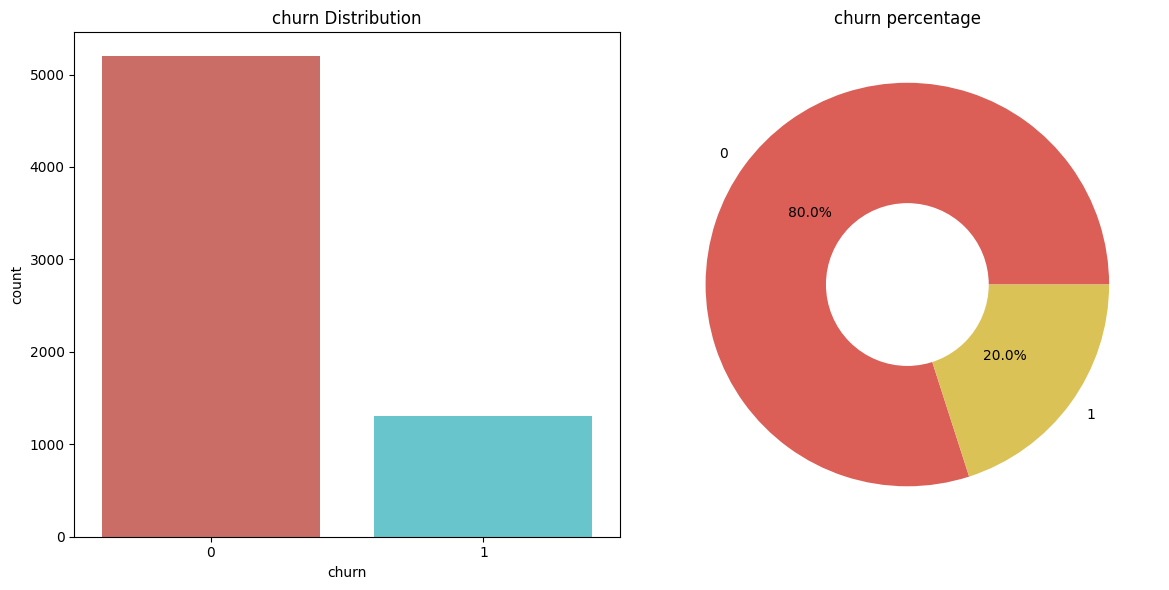

In [60]:
# Visualizing the target variable - churn

univariate_visual(churn_df, 'churn')

The rate at which customers churn is 20%.

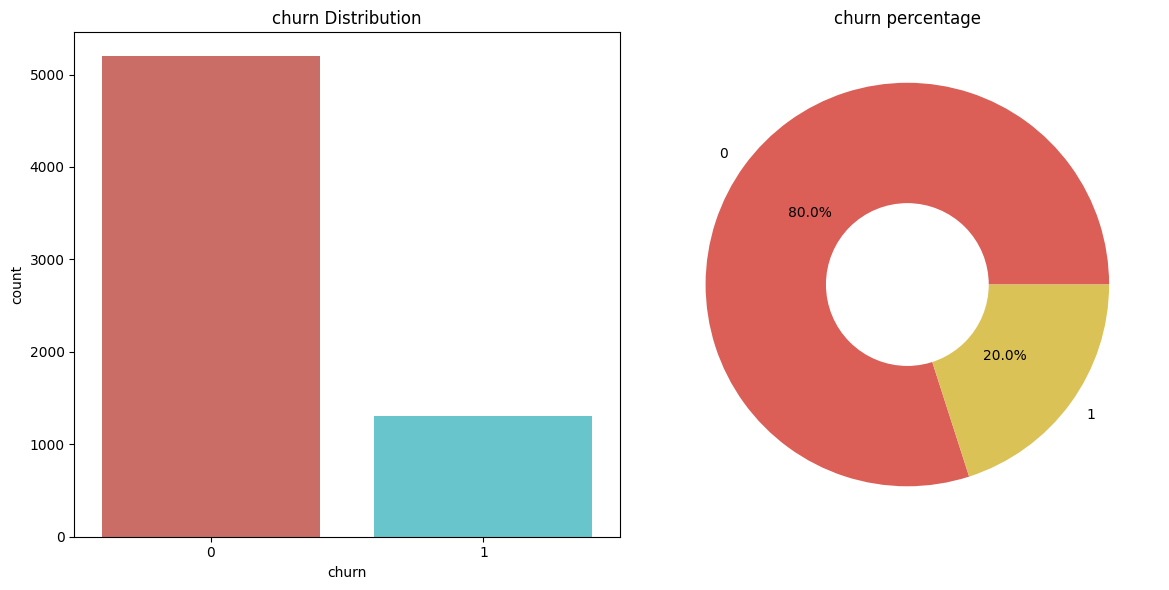

In [61]:
# Visualizing the target variable - churn

univariate_visual(churn_df, 'churn')

2. How many telecom partners are there and what does the distriution of their customers look like?

In [62]:
# Telecom_partner distribution
churn_df['telecom_partner'].value_counts()#(normalize=True)*100

Reliance Jio    1658
BSNL            1635
Vodafone        1609
Airtel          1598
Name: telecom_partner, dtype: int64

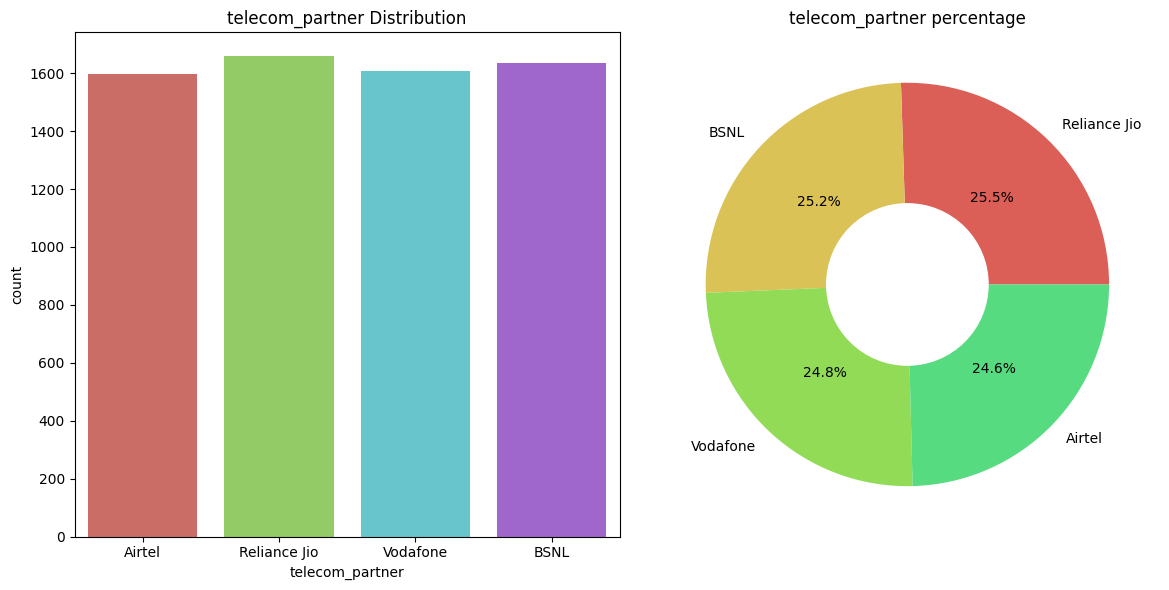

In [63]:
# Visualizing the telecom_partner distribution

univariate_visual(churn_df, 'telecom_partner')

There are four telecom partners and the almost have the same amount of customer distribution
* Reliance Jio takes the lead with a distribution of - 1658 (25.5%) customers .
* While Airtel occupies the last position with a distriution of - 1598 (24.6) customers.

3. Which gender has the highest patronage?

In [64]:
# Gender distribution

churn_df['gender'].value_counts()#(normalize=True)*100

M    3909
F    2591
Name: gender, dtype: int64

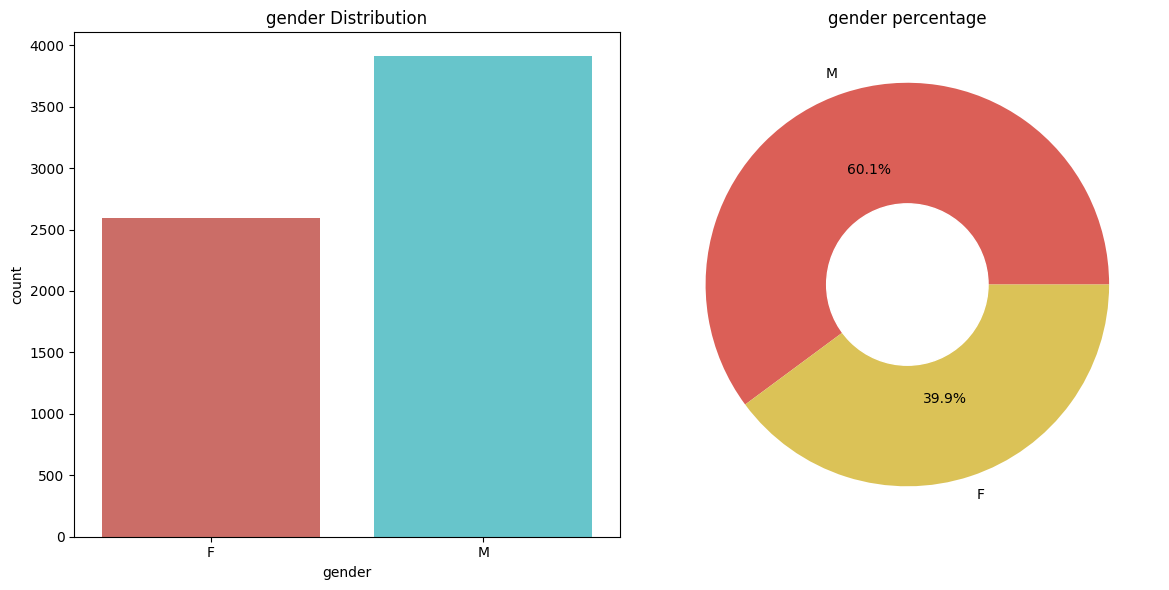

In [65]:
# Visualizing the gender distribution

univariate_visual(churn_df, 'gender')

Apparently men have a higher patronage than women.

4. Which state houses the largest pool of these telecom customers?

In [66]:
# State distribution

churn_df['state'].value_counts()#(normalize=True)*100

Karnataka            260
Jharkhand            256
Madhya Pradesh       256
Chhattisgarh         248
Mizoram              248
Maharashtra          243
Goa                  242
Arunachal Pradesh    240
Meghalaya            238
Nagaland             237
Odisha               237
Tamil Nadu           235
Sikkim               235
Haryana              232
Himachal Pradesh     232
Manipur              230
Punjab               229
Uttarakhand          227
Telangana            227
Andhra Pradesh       225
Gujarat              224
Rajasthan            223
Assam                222
West Bengal          219
Bihar                217
Tripura              215
Uttar Pradesh        203
Kerala               200
Name: state, dtype: int64

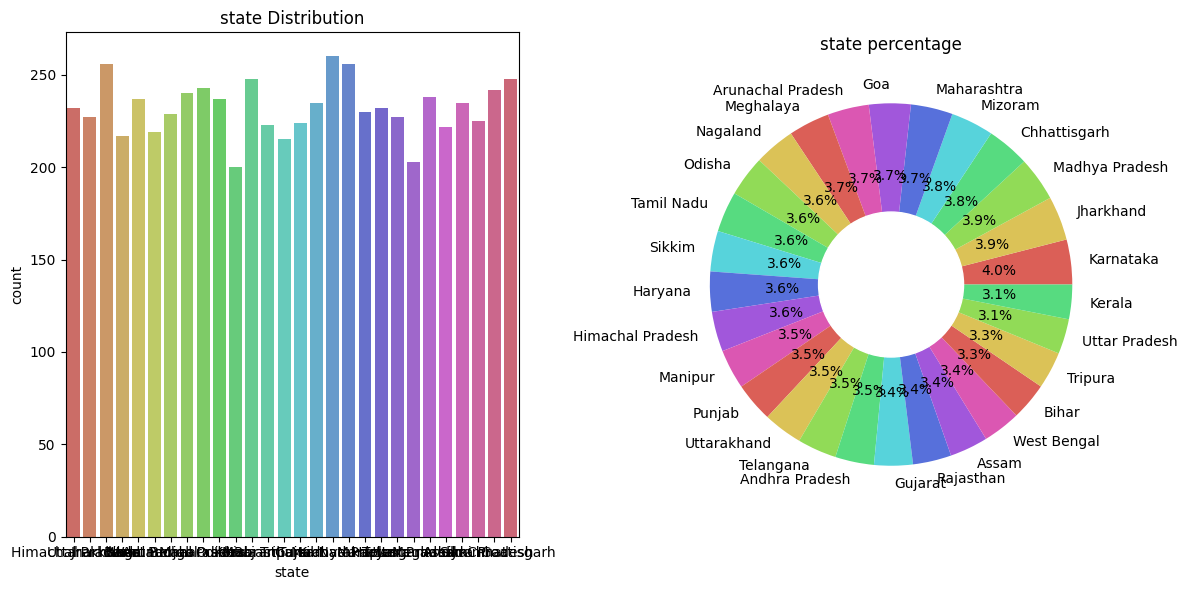

In [67]:
# Visualizing the state distribution

univariate_visual(churn_df, 'state')

The state with the highest distribution of customers is Karnataka with up to 260 (4%) customers
***Note***
* There is much significant difference in the distribution as the state with the lowest number of customers Kerala has up to 200 (3.1%) customers 

5. Which city has the highest concentration of telecom customers? 

In [68]:
# City distribution

churn_df['city'].value_counts()#(normalize=True)*100

Delhi        1128
Chennai      1093
Mumbai       1090
Hyderabad    1068
Bangalore    1066
Kolkata      1055
Name: city, dtype: int64

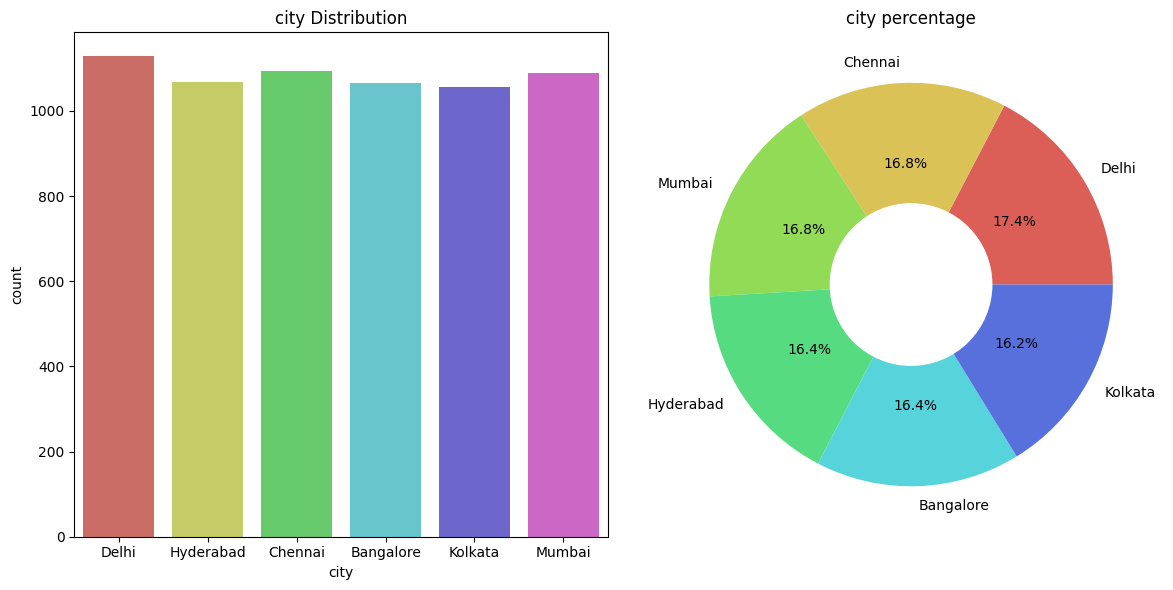

In [69]:
# Visualizing the city distribution

univariate_visual(churn_df, 'city')

Delhi seems to be taking the led as about 1128 (17.4%) telecom customers resides in Delhi

6. What percentage of the telecom customers do not have dependents?

In [70]:
# Dependents distribution

churn_df['num_dependents'].value_counts()#(normalize=True)*100

2    1343
1    1316
0    1299
3    1285
4    1257
Name: num_dependents, dtype: int64

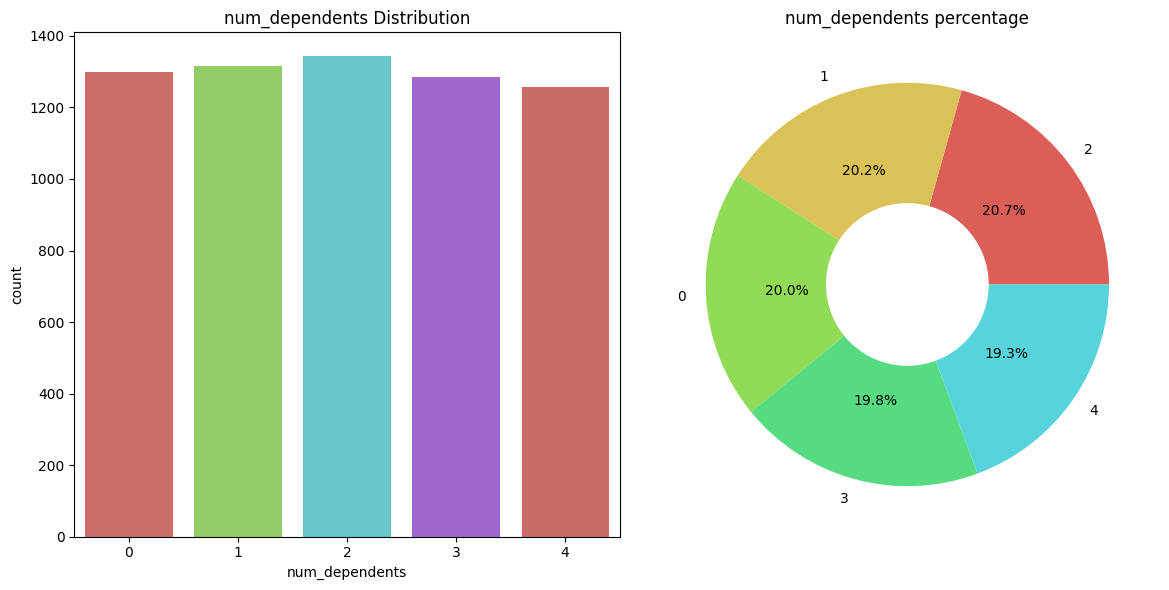

In [71]:
# Visualizing the telecom_partner distribution

univariate_visual(churn_df, 'num_dependents')

20% (1299) of the telecom customers do not have depandents of any sort, while the remaining 80% have dependents ranging from 1 - 4.

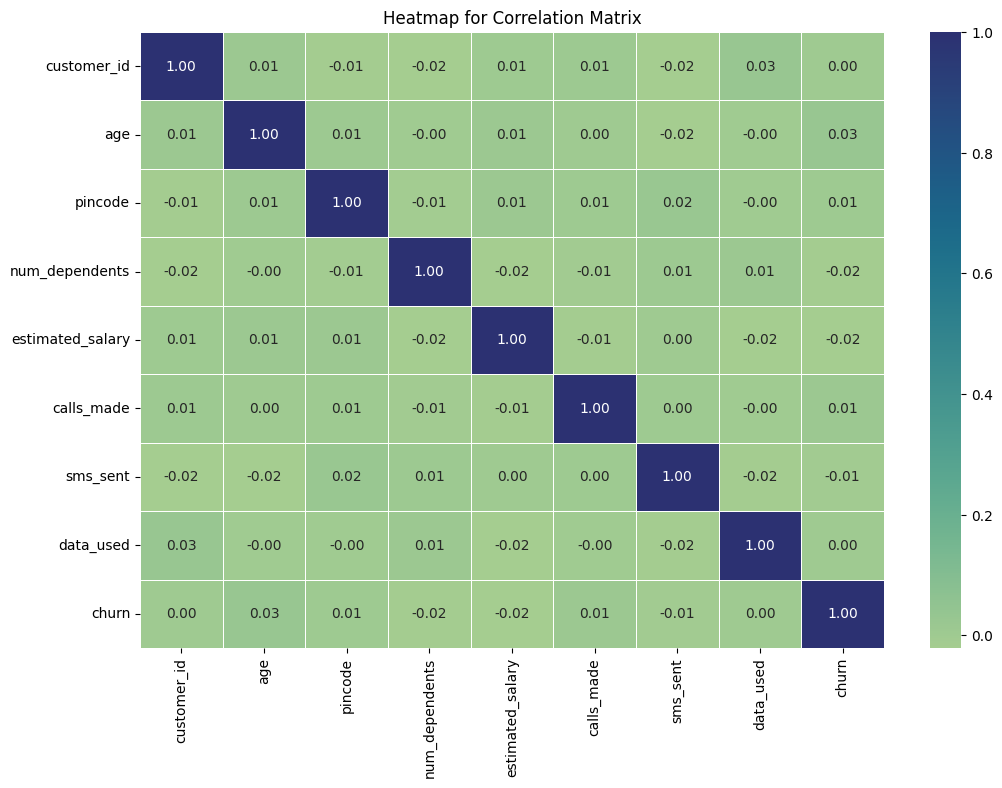

In [72]:
# Plotting Heatmap for better visualization of the correlation of variables
plt.figure(figsize=(12,8))
sns.heatmap(churn_df.corr(), annot=True, cmap='crest', fmt='.2f', linewidths=.5)
plt.title("Heatmap for Correlation Matrix")
plt.show()

In [73]:
# Identifying the categorical variables

cat_cols = list(churn_df.select_dtypes('object'))
churn_df[cat_cols].head()

,telecom_partner,gender,state,city,registration_event
0,Airtel,F,Himachal Pradesh,Delhi,2020-03-16
1,Airtel,F,Uttarakhand,Hyderabad,2022-01-16
2,Airtel,F,Jharkhand,Chennai,2022-01-11
3,Reliance Jio,M,Bihar,Hyderabad,2022-07-26
4,Vodafone,M,Nagaland,Bangalore,2020-03-11


In [74]:
# Identifying the numerical variables

num_cols = list(churn_df.select_dtypes('number'))
churn_df[num_cols].head()

,customer_id,age,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,15169,26,667173,4,85979,75,21,4532,1
1,149207,74,313997,0,69445,35,38,723,1
2,148119,54,549925,2,75949,70,47,4688,1
3,187288,29,230636,3,34272,95,32,10241,1
4,14016,45,188036,4,34157,66,23,5246,1


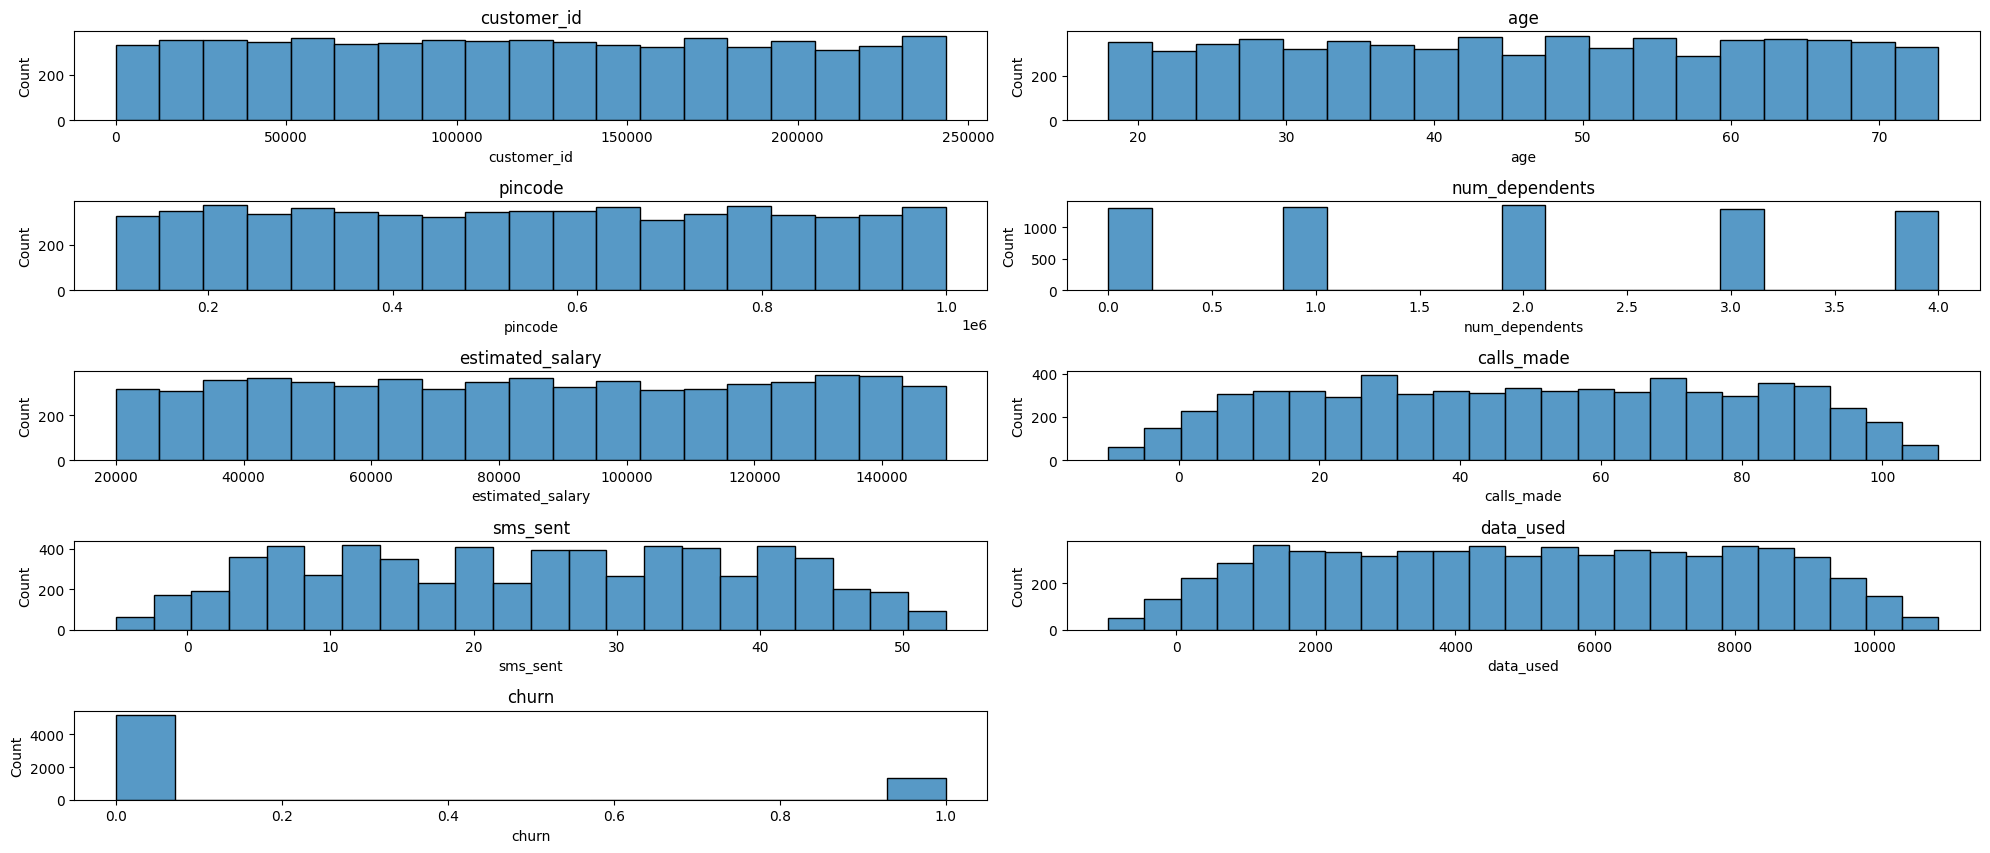

In [75]:
# Visualizing the distribution of numerical columns
plt.figure(figsize=(20, 15))

# Loop through each numerical column
for i, col in enumerate(num_cols):
    # Create a subplot for each column
    plt.subplot(len(num_cols), 2, i+1)
    
    # Visualize the distribution using histogram
    sns.histplot(data=churn_df, x=col)
    
    # Set title and adjust layout
    plt.title(col)
    plt.tight_layout()

# Display the subplots as a single plot
plt.show()


# Data Preprocessing

In [76]:
# Checking for missing values
print(f'The churn DataFrame has {(churn_df.isnull().sum()).sum()} missing values')

The churn DataFrame has 0 missing values


In [77]:
num_cols

['customer_id',
 'age',
 'pincode',
 'num_dependents',
 'estimated_salary',
 'calls_made',
 'sms_sent',
 'data_used',
 'churn']

In [78]:
num_cols.remove('churn')

In [79]:
num_cols.remove('num_dependents')

In [80]:
# Encoding the categorical columns

# Label encode object
encoder = LabelEncoder()

# Apply LabelEncoder to each of the categorical columns
for col in cat_cols:
    churn_df[col] = encoder.fit_transform(churn_df[col])

# Print the head of the dataframe
churn_df.head()

,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,15169,0,0,26,8,2,667173,75,4,85979,75,21,4532,1
1,149207,0,0,74,26,3,313997,743,0,69445,35,38,723,1
2,148119,0,0,54,9,1,549925,738,2,75949,70,47,4688,1
3,187288,2,1,29,3,3,230636,934,3,34272,95,32,10241,1
4,14016,3,1,45,17,0,188036,70,4,34157,66,23,5246,1


In [81]:
# Scaling the numerical columns

# Standard scaler object
scaler = MinMaxScaler()

# Apply the MinMaxScaler object
churn_df[num_cols] = scaler.fit_transform(churn_df[num_cols])

# Print the head of the datafrae
churn_df.head()

,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,0.062113,0,0,0.142857,8,2,0.630356,75,4,0.507617,0.720339,0.448276,0.462736,1
1,0.612672,0,0,1.000000,26,3,0.237805,743,0,0.380409,0.381356,0.741379,0.142328,1
2,0.608203,0,0,0.642857,9,1,0.500036,738,2,0.430449,0.677966,0.896552,0.475858,1
3,0.769090,2,1,0.196429,3,3,0.145150,934,3,0.109797,0.889831,0.637931,0.942968,1
4,0.057377,3,1,0.482143,17,0,0.097801,70,4,0.108912,0.644068,0.482759,0.522796,1


The percentage of non-churn class : 0.80
The percentage of churn class : 0.20


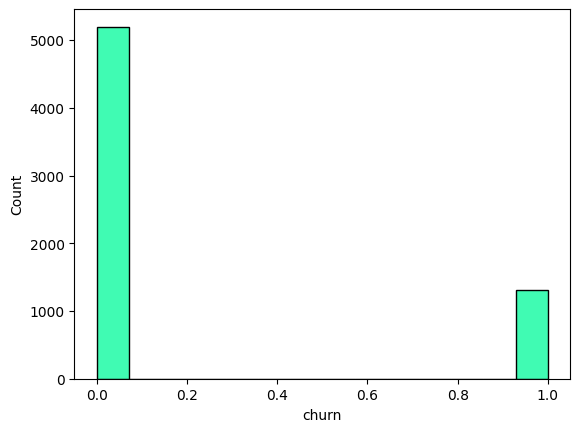

In [82]:
# Checking for data imbalance

sns.histplot(churn_df['churn'], color='mediumspringgreen')
print('The percentage of non-churn class : %.2f' % (churn_df['churn'].value_counts()[0] / len(churn_df)))
print('The percentage of churn class : %.2f' % (churn_df['churn'].value_counts()[1] / len(churn_df)))

The data certainly imbalanced, here is why;
Threshold for Imbalance:
There isn’t a strict threshold, a common rule of thumb suggests that a ratio of more than 10:1 between the majority and minority class indicates data imbalance.

In this case, the non-churn class (80%) is significantly more frequent than the churn class (20%).
The ratio between them is approximately 8:2 or 4:1 (80% / 20%).
While this ratio is higher than 10:1, it still suggests a noticeable imbalance.

**Handling Data Imbalance**  
We will be using SMOTE (Synthetic Minority Oversampling Technique) for this

In [83]:
# Checking the class distribution before SMOTE

print("Class Distribution Before SMOTE:")
churn_df['churn'].value_counts()

Class Distribution Before SMOTE:


0    5197
1    1303
Name: churn, dtype: int64

In [84]:
# Separating the features and target variable

features_scaled = churn_df.drop(['churn', 'customer_id'], axis=1)
target = churn_df['churn']

In [85]:
# Checking the shape of the features and target variable before applying SMOTE

print(features_scaled.shape, target.shape)

(6500, 12) (6500,)


In [86]:
# Apply SMOTE to the data to create synthetic samples for the minority class, addressing data imbalance.

smote = SMOTE(k_neighbors=5, random_state=42)
X_smote, y_smote = smote.fit_resample(features_scaled, target)

In [87]:
# Checking the shape of the features and target variable before after SMOTE

print(X_smote.shape, y_smote.shape)

(10394, 12) (10394,)


# Training the Models

In [88]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [89]:
# Define the models to train
models = [
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier())
]

In [90]:
# Train and evaluate each model using cross-validation
model_scores = {}
for name, model in models:
  kfold = KFold(n_splits=5, shuffle=True, random_state=42)
  # Perform cross-validation and store the score
  score = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
  # Print model name and average accuracy
  print(f"{name} accuracy: {score.mean():.4f}")

  # Storing the model name and its corresponding score in a dictionary
  model_scores[name] = score.mean()

# Find the best performing model based on cross-validation score
higher_accuracy, best_model_score = max(model_scores.items(), key=lambda item: item[1])

print('-'*50, '\n') 
print(f"Best Model: {higher_accuracy} with score: {best_model_score:.4f}")


Logistic Regression accuracy: 0.6079
Random Forest accuracy: 0.7622
-------------------------------------------------- 

Best Model: Random Forest with score: 0.7622


In [91]:
# Find the best model by iterating through the models list
for name, model in models:
  if name != higher_accuracy:
    log = name
    logreg = model
    # Fit the current model with training data
    logreg.fit(X_train, y_train)
  else:
    best_model = model
    # Fit the best model with training data
    best_model.fit(X_train, y_train) 
    #break  # Exit the loop after finding the best model

# predict on the test set 
logreg_pred = logreg.predict(X_test)
rf_pred = best_model.predict(X_test)

# Print the test predictions 
print(f"Test predictions for {log}: {logreg_pred}")
print(f"Test predictions for {higher_accuracy}: {rf_pred}")

Test predictions for Logistic Regression: [0 1 1 ... 0 0 1]
Test predictions for Random Forest: [1 0 1 ... 0 0 0]


In [92]:
# Checking the performance Metrics of the models on the test set
print("Logistic Regression Metrics")
print( "_" * 50)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, logreg_pred))
print("\nClassification Report:\n", classification_report(y_test, logreg_pred))
print("_" * 100)
print("\nRandom Forest Metrics")
print( "_" * 50)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

Logistic Regression Metrics
__________________________________________________

Confusion Matrix:
 [[629 426]
 [418 606]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60      1055
           1       0.59      0.59      0.59      1024

    accuracy                           0.59      2079
   macro avg       0.59      0.59      0.59      2079
weighted avg       0.59      0.59      0.59      2079

____________________________________________________________________________________________________

Random Forest Metrics
__________________________________________________

Confusion Matrix:
 [[849 206]
 [251 773]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.79      1055
           1       0.79      0.75      0.77      1024

    accuracy                           0.78      2079
   macro avg       0.78      0.78      0.78      2079
weighted av